In [1]:
import pandas as pd  
import numpy as np  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler  
from xgboost import XGBClassifier
import xgboost as xgb  
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.model_selection import GridSearchCV  
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import precision_score, recall_score, fbeta_score, classification_report  

In [2]:
file_dir="./data"
syms=list(range(10))
dates = list(range(157))
data_frames = []
count=0
for sym in syms:
    for date in dates:
        if date%2==0:
            file_name=f"snapshot_sym{sym}_date{date//2}_am.csv"
        else:
            file_name=f"snapshot_sym{sym}_date{date//2}_pm.csv"
        try:
            data_frames.append(pd.read_csv(os.path.join(file_dir, file_name)))
            count+=1
        except FileNotFoundError:
            pass
    

df = pd.concat(data_frames)
print(count)

1512


In [4]:
df

,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,n_bsize2,...,n_asize3,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60
0,0,09:40:03,0,0.015691,2594895.0,0.015270,0.015130,1.961524e-06,0.014850,9.973850e-07,...,1.005697e-05,0.016251,4.887187e-06,0.016531,1.645685e-05,1.0,0.0,0.0,0.0,0.0
1,0,09:40:06,0,0.015410,837314.0,0.015410,0.015130,3.424355e-06,0.014850,1.030631e-06,...,5.053418e-06,0.016531,1.649010e-05,0.016811,1.828539e-05,0.0,0.0,0.0,0.0,0.0
2,0,09:40:09,0,0.015130,184807.0,0.015270,0.015130,3.158386e-06,0.014850,9.807620e-07,...,1.083825e-05,0.016251,5.053418e-06,0.016531,1.657321e-05,1.0,0.0,0.0,0.0,0.0
3,0,09:40:12,0,0.015691,500046.0,0.015551,0.015410,4.155771e-07,0.015130,2.044639e-06,...,5.053418e-06,0.016531,1.622413e-05,0.016811,1.828539e-05,0.0,0.0,0.0,0.0,0.0
4,0,09:40:15,0,0.014290,1785635.0,0.014710,0.014290,9.308927e-06,0.014010,4.986925e-08,...,3.612296e-05,0.015971,9.159319e-06,0.016251,4.920433e-06,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,78,11:19:45,9,-0.007521,1647328.0,-0.007463,-0.007521,1.367597e-06,-0.007636,8.050769e-07,...,2.297563e-07,-0.006711,2.789898e-07,-0.006595,3.446891e-07,1.0,2.0,1.0,1.0,2.0
1995,78,11:19:48,9,-0.007405,806389.0,-0.007463,-0.007521,1.148781e-06,-0.007636,8.050769e-07,...,2.297563e-07,-0.006711,2.789898e-07,-0.006595,2.407517e-07,1.0,1.0,1.0,1.0,2.0
1996,78,11:19:51,9,-0.007405,514693.0,-0.007463,-0.007521,8.862027e-07,-0.007636,8.050769e-07,...,2.297563e-07,-0.006711,2.188155e-08,-0.006595,2.407517e-07,1.0,2.0,1.0,1.0,1.0
1997,78,11:19:54,9,-0.007405,634797.0,-0.007347,-0.007405,3.282232e-08,-0.007521,6.072130e-07,...,2.188155e-08,-0.006595,2.407517e-07,-0.006364,6.564465e-08,1.0,1.0,1.0,1.0,1.0


## 特征工程提取

In [3]:
# 复制原始数据  
new_df = df.copy()  

# 价格+1  
new_df['bid1'] = new_df['n_bid1'] + 1  
new_df['bid2'] = new_df['n_bid2'] + 1  
new_df['bid3'] = new_df['n_bid3'] + 1  
new_df['bid4'] = new_df['n_bid4'] + 1  
new_df['bid5'] = new_df['n_bid5'] + 1  

new_df['ask1'] = new_df['n_ask1'] + 1  
new_df['ask2'] = new_df['n_ask2'] + 1  
new_df['ask3'] = new_df['n_ask3'] + 1  
new_df['ask4'] = new_df['n_ask4'] + 1  
new_df['ask5'] = new_df['n_ask5'] + 1  

# 交易量取对数  
new_df['bsize1'] = new_df['n_bsize1'].map(np.log)  
new_df['bsize2'] = new_df['n_bsize2'].map(np.log)  
new_df['bsize3'] = new_df['n_bsize3'].map(np.log)  
new_df['bsize4'] = new_df['n_bsize4'].map(np.log)  
new_df['bsize5'] = new_df['n_bsize5'].map(np.log)  

new_df['asize1'] = new_df['n_asize1'].map(np.log)  
new_df['asize2'] = new_df['n_asize2'].map(np.log)  
new_df['asize3'] = new_df['n_asize3'].map(np.log)  
new_df['asize4'] = new_df['n_asize4'].map(np.log)  
new_df['asize5'] = new_df['n_asize5'].map(np.log)  

new_df['amount'] = new_df['amount_delta'].map(np.log1p)  

# 价格差  
new_df['spread1'] = new_df['ask1'] - new_df['bid1']  
new_df['spread2'] = new_df['ask2'] - new_df['bid2']  
new_df['spread3'] = new_df['ask3'] - new_df['bid3']  

new_df['mid_price1'] = (new_df['ask1'] + new_df['bid1']) / 2  
new_df['mid_price2'] = (new_df['ask2'] + new_df['bid2']) / 2  
new_df['mid_price3'] = (new_df['ask3'] + new_df['bid3']) / 2  

# 加权平均价格  
new_df['weighted_ab1'] = (new_df['ask1'] * new_df['n_asize1'] + new_df['bid1'] * new_df['n_bsize1']) / (new_df['n_asize1'] + new_df['n_bsize1'])  
new_df['weighted_ab2'] = (new_df['ask2'] * new_df['n_asize2'] + new_df['bid2'] * new_df['n_bsize2']) / (new_df['n_asize2'] + new_df['n_bsize2'])  
new_df['weighted_ab3'] = (new_df['ask3'] * new_df['n_asize3'] + new_df['bid3'] * new_df['n_bsize3']) / (new_df['n_asize3'] + new_df['n_bsize3'])  

new_df['relative_spread1'] = new_df['spread1'] / new_df['mid_price1']  
new_df['relative_spread2'] = new_df['spread2'] / new_df['mid_price2']  
new_df['relative_spread3'] = new_df['spread3'] / new_df['mid_price3']  

new_df['ask1_ma5'] = new_df['ask1'].rolling(window=5, min_periods=1).mean()  
new_df['ask1_ma10'] = new_df['ask1'].rolling(window=10, min_periods=1).mean()  
new_df['ask1_ma20'] = new_df['ask1'].rolling(window=20, min_periods=1).mean()  
new_df['ask1_ma40'] = new_df['ask1'].rolling(window=40, min_periods=1).mean()  
new_df['ask1_ma60'] = new_df['ask1'].rolling(window=60, min_periods=1).mean()  

new_df['bid1_ma5'] = new_df['bid1'].rolling(window=5, min_periods=1).mean()  
new_df['bid1_ma10'] = new_df['bid1'].rolling(window=10, min_periods=1).mean()  
new_df['bid1_ma20'] = new_df['bid1'].rolling(window=20, min_periods=1).mean()  
new_df['bid1_ma40'] = new_df['bid1'].rolling(window=40, min_periods=1).mean()  
new_df['bid1_ma60'] = new_df['bid1'].rolling(window=60, min_periods=1).mean()  

# 新特征：中间价变化趋势  
new_df['mid_price1_range5'] = new_df['mid_price1'] - new_df['mid_price1'].shift(5)  
new_df['mid_price1_range10'] = new_df['mid_price1'] - new_df['mid_price1'].shift(10)  
new_df['mid_price1_range20'] = new_df['mid_price1'] - new_df['mid_price1'].shift(20)  

# 新特征：一档/三档报单量占总报单量比值  
new_df['all_size'] = new_df['n_bsize1'] + new_df['n_bsize2'] + new_df['n_bsize3'] + new_df['n_bsize4'] + new_df['n_bsize5'] + \
                     new_df['n_asize1'] + new_df['n_asize2'] + new_df['n_asize3'] + new_df['n_asize4'] + new_df['n_asize5']  
new_df['bsize_asize_1'] = (new_df['n_bsize1'] + new_df['n_asize1']) / new_df['all_size']  
new_df['bsize_asize_3'] = (new_df['all_size'] - new_df['n_bsize4'] - new_df['n_bsize5'] - new_df['n_asize4'] - new_df['n_asize5']) / new_df['all_size']  

# 新特征：买卖报单量差与交易量结合  
new_df['bsize_over_asize'] = (new_df['n_bsize1'] + new_df['n_bsize2'] + new_df['n_bsize3'] + new_df['n_bsize4'] + new_df['n_bsize5'] -   
                              (new_df['n_asize1'] + new_df['n_asize2'] + new_df['n_asize3'] + new_df['n_asize4'] + new_df['n_asize5'])) / \
                             (new_df['n_bsize1'] + new_df['n_bsize2'] + new_df['n_bsize3'] + new_df['n_bsize4'] + new_df['n_bsize5'] +   
                              new_df['n_asize1'] + new_df['n_asize2'] + new_df['n_asize3'] + new_df['n_asize4'] + new_df['n_asize5'])  
new_df['amount_size'] = new_df['amount'] * new_df['bsize_over_asize']

# 计算 vol1_rel_diff  
new_df['vol1_rel_diff'] = (new_df['n_bsize1'] - new_df['n_asize1']) / \
                          (new_df['n_bsize1'] + new_df['n_asize1'])  
# 计算 volall_rel_diff  
new_df['volall_rel_diff'] = (  
    (new_df['n_bsize1'] + new_df['n_bsize2'] + new_df['n_bsize3'] + new_df['n_bsize4'] + new_df['n_bsize5'] -  
     new_df['n_asize1'] - new_df['n_asize2'] - new_df['n_asize3'] - new_df['n_asize4'] - new_df['n_asize5']) /  
    (new_df['n_bsize1'] + new_df['n_bsize2'] + new_df['n_bsize3'] + new_df['n_bsize4'] + new_df['n_bsize5'] +  
     new_df['n_asize1'] + new_df['n_asize2'] + new_df['n_asize3'] + new_df['n_asize4'] + new_df['n_asize5'])  
)  

/Users/lissu/miniconda3/envs/quant/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: divide by zero encountered in log
  return lib.map_infer(values, mapper, convert=convert)
/Users/lissu/miniconda3/envs/quant/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: divide by zero encountered in log
  return lib.map_infer(values, mapper, convert=convert)
/Users/lissu/miniconda3/envs/quant/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: divide by zero encountered in log
  return lib.map_infer(values, mapper, convert=convert)
/Users/lissu/miniconda3/envs/quant/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: divide by zero encountered in log
  return lib.map_infer(values, mapper, convert=convert)
/Users/lissu/miniconda3/envs/quant/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: divide by zero encountered in log
  return lib.map_infer(values, mapper, convert=conv

In [4]:
feature_col_names = [  
    # 原始特征  
    'n_bid1', 'n_bid2', 'n_bid3', 'n_bid4', 'n_bid5',  
    'n_ask1', 'n_ask2', 'n_ask3', 'n_ask4', 'n_ask5',  
    'n_asize1', 'n_asize2', 'n_asize3', 'n_asize4', 'n_asize5',  
    'n_bsize1', 'n_bsize2', 'n_bsize3', 'n_bsize4', 'n_bsize5',  
    'amount_delta', 'n_midprice',   

    # 价格差  
    'spread1', 'spread2', 'spread3',  

    # 中间价  
    'mid_price1', 'mid_price2', 'mid_price3',  

    # 加权平均价格  
    'weighted_ab1', 'weighted_ab2', 'weighted_ab3',  

    # 相对价差  
    'relative_spread1', 'relative_spread2', 'relative_spread3',  

    # 移动平均价格  
    'ask1_ma5', 'ask1_ma10', 'ask1_ma20', 'ask1_ma40', 'ask1_ma60',  
    'bid1_ma5', 'bid1_ma10', 'bid1_ma20', 'bid1_ma40', 'bid1_ma60',  

    # 中间价变化趋势  
    'mid_price1_range5', 'mid_price1_range10', 'mid_price1_range20',  

    # 一档/三档报单量占总报单量比值  
    'bsize_asize_1', 'bsize_asize_3',  

    # 买卖报单量差与交易量结合  
    'bsize_over_asize', 'amount_size',

    'vol1_rel_diff', 'volall_rel_diff'
]
label_col_name = ['label_5']

In [5]:
np.random.seed(625)  

# 为数据添加一个随机列用于分割  
new_df['random'] = np.random.rand(len(new_df))  

# 按照随机列将数据分为 99% 的训练集和 1% 的测试集  
train_df = new_df[new_df['random'] <= 0.99].drop(columns=['random'])  
test_df = new_df[new_df['random'] > 0.99].drop(columns=['random'])  

# 提取训练和测试数据  
train_data = np.ascontiguousarray(train_df[feature_col_names].values)  
train_label = train_df[label_col_name].values.reshape(-1)  

test_data = np.ascontiguousarray(test_df[feature_col_names].values)  
test_label = test_df[label_col_name].values.reshape(-1)

In [6]:
nan_indices = np.isnan(train_data).any(axis=1)  

# 删除 train_data 和 train_label 中对应的行  
train_data = train_data[~nan_indices]  
train_label = train_label[~nan_indices]  

nan_indices = np.isnan(test_data).any(axis=1)  

# 删除 train_data 和 train_label 中对应的行  
test_data = test_data[~nan_indices]  
test_label = test_label[~nan_indices]  

In [48]:
class_counts = Counter(train_label)  
total_samples = len(train_label)  
class_weight = {cls: total_samples / count for cls, count in class_counts.items()}  
print("类别权重：", class_weight)  

# 为每个样本分配权重  
sample_weights = [class_weight[label] for label in train_label]  
# 设置 XGBClassifier 的参数  
model = XGBClassifier(  
    objective='multi:softmax',  # 多分类问题，直接输出类别  
    num_class=3,  # 类别数量  
    learning_rate=0.05,  # 学习率  
    max_depth=6,  # 增加模型复杂度  
    min_child_weight=3,  # 控制叶子节点的最小权重  
    n_estimators=500,  # 增加训练轮数  
    subsample=0.8,  # 随机采样比例，防止过拟合  
    colsample_bytree=0.8,  # 每棵树使用的特征比例  
    eval_metric='mlogloss'  # 多分类对数损失  
) 

# 训练模型  
model.fit(train_data, train_label, sample_weight=sample_weights, verbose=True) 

# 保存最优模型  
model.save_model('best_model_label5.json') 

y_pred = model.predict(test_data) 
y=test_label

# 输出分类报告  
print("\nClassification Report:")  
print(classification_report(test_label, y_pred))  


类别权重： {1.0: 1.4322486585502756, 0.0: 6.602071206323331, 2.0: 6.652049963525373}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.36      0.64      0.46      4535
         1.0       0.91      0.59      0.72     20691
         2.0       0.37      0.65      0.47      4544

    accuracy                           0.61     29770
   macro avg       0.54      0.63      0.55     29770
weighted avg       0.74      0.61      0.64     29770



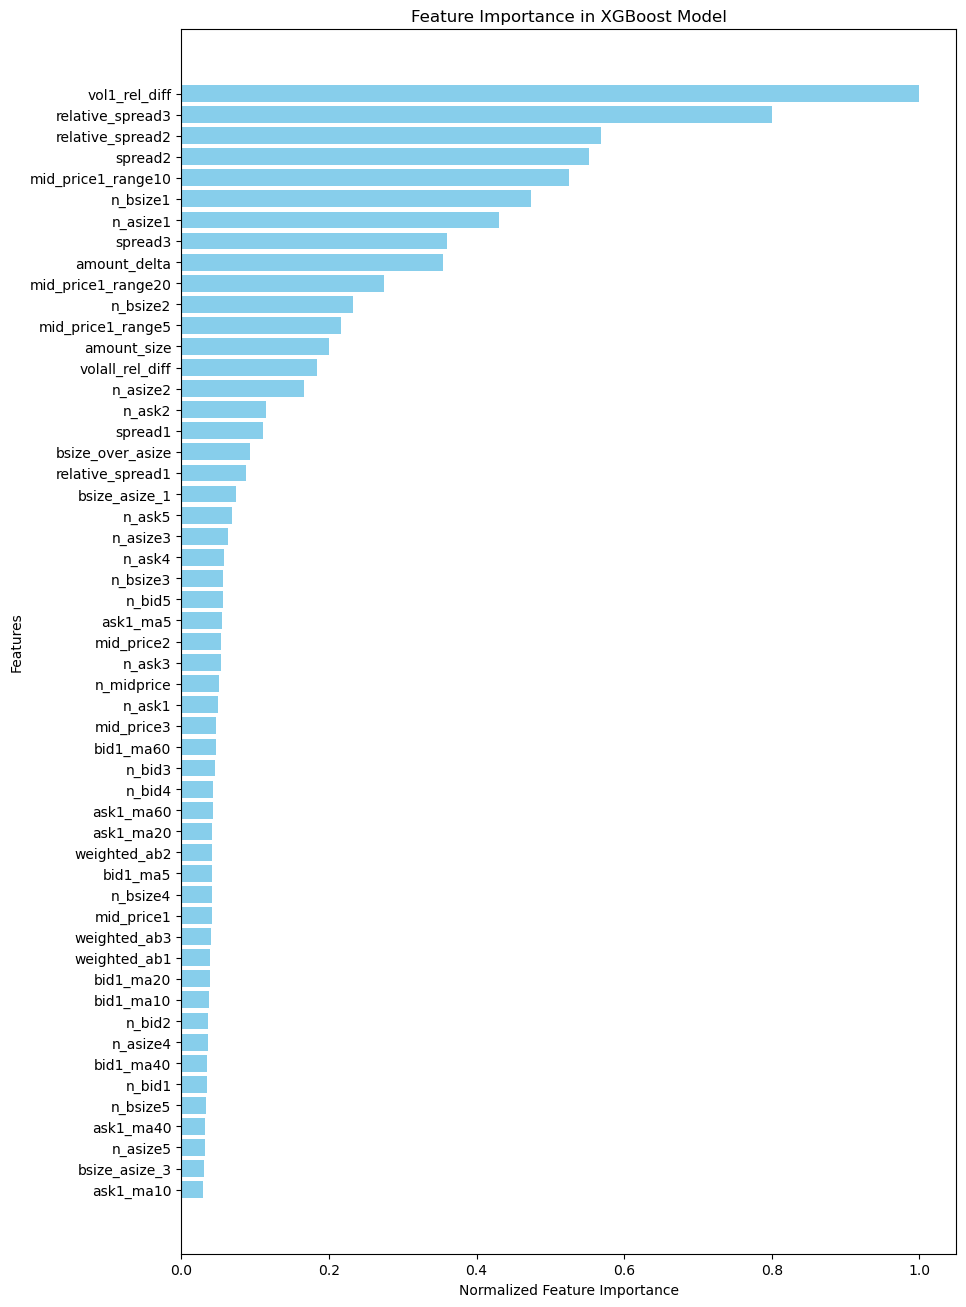

In [49]:
importance = model.feature_importances_  
importance_normalized = importance / np.max(importance)  # 归一化处理  
# 将特征和重要性组合成 DataFrame 并排序  
importance_df = pd.DataFrame({  
    'Feature': feature_col_names,  
    'Importance': importance_normalized  
}).sort_values(by='Importance', ascending=False)  

# 可视化特征重要性（按大小排序）  
# 调整图表高度  
plt.figure(figsize=(10, len(importance_df) * 0.3))  # 根据特征数量动态调整高度  
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')  
plt.xlabel('Normalized Feature Importance')  
plt.ylabel('Features')  
plt.title('Feature Importance in XGBoost Model')  
plt.gca().invert_yaxis()  # 反转 y 轴，使重要性最高的特征在顶部  
plt.show()

In [9]:
class_counts = Counter(train_label)  
total_samples = len(train_label)  
class_weight = {cls: total_samples / count for cls, count in class_counts.items()}  
print("类别权重：", class_weight)  

# 为每个样本分配权重  
sample_weights = [class_weight[label] for label in train_label]  

# 设置 XGBClassifier 的参数  
model = XGBClassifier(  
    objective='multi:softmax',  # 多分类问题，直接输出类别  
    num_class=3,  # 类别数量  
    learning_rate=0.05,  # 学习率  
    max_depth=6,  # 增加模型复杂度  
    min_child_weight=3,  # 控制叶子节点的最小权重  
    n_estimators=500,  # 增加训练轮数  
    subsample=0.8,  # 随机采样比例，防止过拟合  
    colsample_bytree=0.8,  # 每棵树使用的特征比例  
    eval_metric='mlogloss'  # 多分类对数损失  
)  

# 训练模型  
model.fit(train_data, train_label, sample_weight=sample_weights, verbose=True)  

# 保存最优模型  
model.save_model('best_model_label5.json')  

# 预测  
y_pred = model.predict(test_data)  

# 输出分类报告  
print("\nClassification Report:")  
print(classification_report(test_label, y_pred))  

类别权重： {1.0: 1.4332101193218663, 0.0: 6.5921224804493885, 2.0: 6.641456085294888}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.35      0.63      0.45      4563
         1.0       0.91      0.59      0.72     20828
         2.0       0.37      0.66      0.48      4583

    accuracy                           0.61     29974
   macro avg       0.54      0.63      0.55     29974
weighted avg       0.74      0.61      0.64     29974

